# Simulation of coherent WDM transmission with nonlinearity compensation using digital backpropagation (DBP)

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 12677, done.
remote: Counting objects: 100% (1890/1890), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 12677 (delta 1827), reused 1746 (delta 1743), pack-reused 10787 (from 2)
Receiving objects: 100% (12677/12677), 242.67 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (9472/9472), done.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.3 MB/s eta 0:00:00
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=102737 sha256=036faca1e261d7b4551f1343ca52105e5e128a1f29eeede2e8f8375f86c88441
 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, decimate, symbolSync, pnorm, signalPower
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
        from optic.models.modelsGPU import manakovSSF, manakovDBP
    else:
        from optic.dsp.core import firFilter
        from optic.models.channels import manakovSSF
        from optic.dsp.equalization import manakovDBP
except ImportError:
    from optic.dsp.core import firFilter
    from optic.models.channels import manakovSSF
    from optic.dsp.equalization import manakovDBP

from optic.models.tx import simpleWDMTx
from optic.utils import parameters, dBm2W, dB2lin
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM


import logging as logg
logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

from copy import deepcopy
from tqdm.notebook import tqdm

/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

In [4]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler


## Evaluation of transmission performance versus fiber launch power with and without single-channel DBP

### Configure Polarization multiplexed WDM signal generation

In [5]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64  # order of the modulation format
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 16  # samples per symbol
paramTx.pulseType = 'rrc' # pulse shaping filter
paramTx.nFilterTaps = 4096 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = 0 # power per WDM channel [dBm]
paramTx.nChannels = 11 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.wdmGridSpacing = 37.5e9 # WDM grid spacing
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization
paramTx.seed = 123 # random seed for bit generation

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

### Nonlinear fiber propagation with the split-step Fourier method + receiver DSP with EDC/single-channel DBP

In [6]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift?
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = False   # show progress bar?
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate
paramCh.seed = 456 # random seed for noise generation

#paramCh.saveSpanN = [1, 5, 9, 14]
Fs = paramTx.Rs*paramTx.SpS # sampling rate

# DBP parameters
paramDBP = deepcopy(paramCh)
paramDBP.nlprMethod = False
paramDBP.hz = 10
runDBP = True

### Receiver parameters

Fc = paramCh.Fc
Ts = 1/Fs
freqGrid = paramTx.wdmFreqGrid

## LO parameters
FO      = 50e6                  # frequency offset
lw      = 100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = dBm2W(Plo_dBm)        # power in W
ϕ_lo    = 0                     # initial phase in rad

## photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.ideal = True
paramPD.seed = 1011

## matched filter parameters
paramMF = parameters()
paramMF.SpS = paramTx.SpS
paramMF.nFilterTaps = paramTx.nFilterTaps
paramMF.rollOff = paramTx.pulseRollOff
paramMF.pulseType = paramTx.pulseType

Powers = paramTx.powerPerChannel + np.arange(-8,0,0.5)
scale = np.arange(-8,0,0.5)

BER = np.zeros((4,len(Powers)))
SER = np.zeros((4,len(Powers)))
MI  = np.zeros((4,len(Powers)))
GMI = np.zeros((4,len(Powers)))
NGMI = np.zeros((4,len(Powers)))
SNR = np.zeros((4,len(Powers)))
EVM = np.zeros((4,len(Powers)))

for indP, G in enumerate(tqdm(scale)):
    # nonlinear signal propagation
    G_lin = dB2lin(G)

    sigWDM = manakovSSF(np.sqrt(G_lin)*sigWDM_Tx, paramCh)
    print('Fiber launch power per WDM channel: ', round(10*np.log10(signalPower(sigWDM)/paramTx.nChannels /1e-3),2),'dBm')

    ### WDM channels coherent detection and demodulation

    ### Receiver

    # parameters
    chIndex  = int(np.floor(paramTx.nChannels/2))      # index of the channel to be demodulated

    symbTx = symbTx_[:,:,chIndex]

    # local oscillator (LO) parameters:
    Δf_lo = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
    π = np.pi

    # generate CW laser LO field
    paramLO = parameters()
    paramLO.P = Plo              # power in dBm
    paramLO.lw = lw          # laser linewidth
    paramLO.RIN_var = 0
    paramLO.Ns = len(sigWDM)
    paramLO.Fs = Fs
    paramLO.seed = 789 # random seed for noise generation

    sigLO = basicLaserModel(paramLO)
    t  = np.arange(0, len(sigWDM))*(1/Fs) # time vector
    sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t)  # add frequency offset

    #### polarization multiplexed coherent optical receiver
    θsig = π/3 # polarization rotation angle
    sigRx_coh = pdmCoherentReceiver(sigWDM, sigLO, θsig, paramPD)

    for runDBP in [True, False]:
        ### Matched filtering and CD compensation

        # Rx filtering

        # Matched filtering
        pulse = pulseShape(paramMF)
        sigRx = firFilter(pulse, sigRx_coh)

        # CD compensation/digital backpropagation
        if runDBP:
            Pch = dBm2W(G + paramTx.powerPerChannel)
            sigRx = np.sqrt(Pch/2)*pnorm(sigRx)
            #print('channel input power (DBP): ', round(10*np.log10(signalPower(sigRx)/1e-3),3),'dBm')

            sigRx = manakovDBP(sigRx, paramDBP)
        else:
            paramEDC = parameters()
            paramEDC.L = paramCh.Ltotal
            paramEDC.D = paramCh.D
            paramEDC.Fc = Fc-Δf_lo
            paramEDC.Fs = Fs
            sigRx = edc(sigRx, paramEDC)

        ### Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences

        # decimation
        paramDec = parameters()
        paramDec.SpSin  = paramTx.SpS
        paramDec.SpSout = 2
        sigRx = decimate(sigRx, paramDec)

        symbRx = symbolSync(sigRx, symbTx, 2)

        ### Power normalization

        x = pnorm(sigRx)
        d = pnorm(symbRx)

        ### Adaptive equalization

        # adaptive equalization parameters
        paramEq = parameters()
        paramEq.nTaps = 15
        paramEq.SpS = paramDec.SpSout
        paramEq.numIter = 5
        paramEq.storeCoeff = False
        paramEq.M = paramTx.M
        paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
        paramEq.prgsBar = False

        if paramTx.M == 4:
            paramEq.alg = ['cma','cma'] # QPSK
            paramEq.mu = [5e-3, 1e-3]
        else:
            paramEq.alg = ['da-rde','rde'] # M-QAM
            paramEq.mu = [2e-3, 5e-4]

        y_EQ = mimoAdaptEqualizer(x, paramEq, d)

        ### Carrier phase recovery

        paramCPR = parameters()
        paramCPR.alg = 'bps'
        paramCPR.M   = paramTx.M
        paramCPR.N   = 75
        paramCPR.B   = 64

        y_CPR = cpr(y_EQ, paramCPR)

        discard = 5000

        ### Evaluate transmission metrics

        ind = np.arange(discard, d.shape[0]-discard)

        # remove phase and polarization ambiguities for QPSK signals
        if paramTx.M == 4:
            d = symbTx
            # find rotations after CPR and/or polarizations swaps possibly added at the output the adaptive equalizer:
            rot0 = [np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,0])), np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,0]))]
            rot1 = [np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,1])), np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,1]))]

            if np.argmax(np.abs(rot0)) == 1 and np.argmax(np.abs(rot1)) == 1:
                y_CPR_ = y_CPR.copy()
                # undo swap and rotation
                y_CPR[:,0] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR_[:,1])
                y_CPR[:,1] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR_[:,0])
            else:
                # undo rotation
                y_CPR[:,0] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR[:,0])
                y_CPR[:,1] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR[:,1])

        if runDBP:
            indsave = np.arange(0,2)
        else:
            indsave = np.arange(2,4)

        BER[indsave,indP], SER[indsave,indP], SNR[indsave,indP] = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        GMI[indsave,indP], NGMI[indsave,indP] = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        MI[indsave,indP] = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        EVM[indsave,indP] = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

        print('      pol.X      pol.Y      ')
        print(' SER: %.2e,  %.2e'%(SER[indsave[0],indP], SER[indsave[1],indP]))
        print(' BER: %.2e,  %.2e'%(BER[indsave[0],indP], BER[indsave[1],indP]))
        print(' SNR: %.2f dB,  %.2f dB'%(SNR[indsave[0],indP], SNR[indsave[1],indP]))
        print(' EVM: %.2f %%,    %.2f %%'%(EVM[indsave[0],indP]*100, EVM[indsave[1],indP]*100))
        print('  MI: %.2f bits, %.2f bits'%(MI[indsave[0],indP], MI[indsave[1],indP]))
        print(' GMI: %.2f bits, %.2f bits'%(GMI[indsave[0],indP], GMI[indsave[1],indP]))
        print('NGMI: %.2f,      %.2f'%(NGMI[indsave[0],indP], NGMI[indsave[1],indP]))

  0%|          | 0/16 [00:00<?, ?it/s]

Fiber launch power per WDM channel:  -7.94 dBm
      pol.X      pol.Y      
 SER: 7.67e-02,  7.67e-02
 BER: 1.30e-02,  1.30e-02
 SNR: 19.41 dB,  19.42 dB
 EVM: 1.15 %,    1.15 %
  MI: 5.70 bits, 5.70 bits
 GMI: 5.70 bits, 5.70 bits
NGMI: 0.95,      0.95
      pol.X      pol.Y      
 SER: 8.55e-02,  8.59e-02
 BER: 1.46e-02,  1.46e-02
 SNR: 19.16 dB,  19.17 dB
 EVM: 1.22 %,    1.22 %
  MI: 5.66 bits, 5.67 bits
 GMI: 5.66 bits, 5.67 bits
NGMI: 0.94,      0.94
Fiber launch power per WDM channel:  -7.44 dBm
      pol.X      pol.Y      
 SER: 5.85e-02,  5.86e-02
 BER: 9.89e-03,  9.86e-03
 SNR: 19.88 dB,  19.88 dB
 EVM: 1.03 %,    1.03 %
  MI: 5.77 bits, 5.77 bits
 GMI: 5.77 bits, 5.77 bits
NGMI: 0.96,      0.96
      pol.X      pol.Y      
 SER: 6.59e-02,  6.49e-02
 BER: 1.12e-02,  1.09e-02
 SNR: 19.67 dB,  19.67 dB
 EVM: 1.08 %,    1.08 %
  MI: 5.74 bits, 5.74 bits
 GMI: 5.74 bits, 5.74 bits
NGMI: 0.96,      0.96
Fiber launch power per WDM channel:  -6.95 dBm
      pol.X      pol.Y      
 S

## Plot transmission results

/tmp/ipython-input-3172535881.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


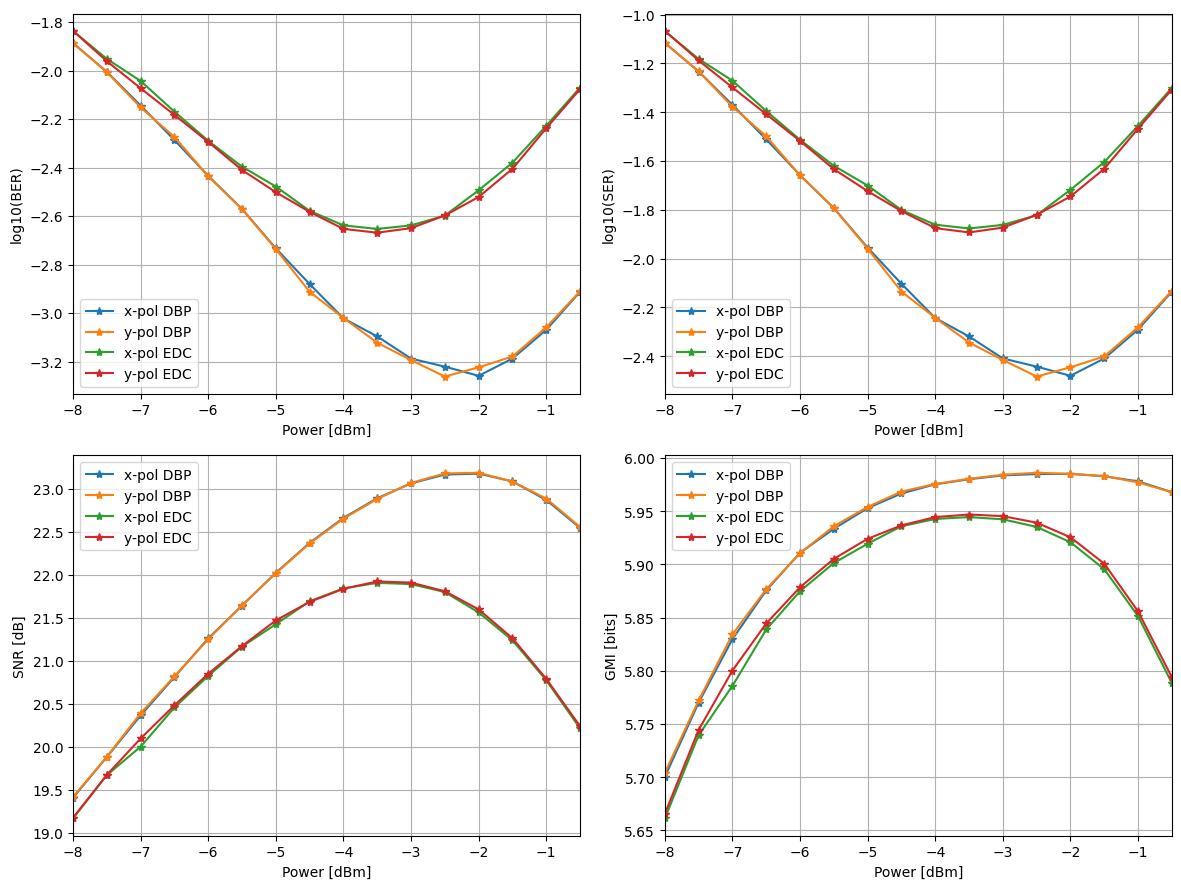

In [14]:
fig, ax = plt.subplots(2,2, layout="constrained", figsize=(12,9))

ax[0,0].plot(Powers, np.log10(BER.T), '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[0,0].set_xlabel('Power [dBm]')
ax[0,0].set_ylabel('log10(BER)')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_box_aspect(0.75)
ax[0,0].set_xlim(min(Powers), max(Powers))

ax[0,1].plot(Powers, np.log10(SER.T), '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[0,1].set_xlabel('Power [dBm]')
ax[0,1].set_ylabel('log10(SER)')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_box_aspect(0.75)
ax[0,1].set_xlim(min(Powers), max(Powers))

ax[1,0].plot(Powers, SNR.T, '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[1,0].set_xlabel('Power [dBm]')
ax[1,0].set_ylabel('SNR [dB]')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_box_aspect(0.75)
ax[1,0].set_xlim(min(Powers), max(Powers))

ax[1,1].plot(Powers, GMI.T, '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[1,1].set_xlabel('Power [dBm]')
ax[1,1].set_ylabel('GMI [bits]')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_box_aspect(0.75);
ax[1,1].set_xlim(min(Powers), max(Powers));

fig.tight_layout();
#fig.set_size_inches(15, 20)